# Analysis for all panels in Figure 2

In [2]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.stats import ttest_ind

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse,Rectangle
import matplotlib.transforms as transforms

import glob
import scipy
import re

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression

In [3]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7
cm = 1/2.54
fig_folder = './Figure_2_exports'
data_folder = '../all_data/Figure_2_data'

## Read in all data

In [4]:
data = pd.read_pickle('../all_data/General_data/screen_active_data.pkl')
data = data[data['label'] == 'screen']

In [5]:
sub_df = []
diff_threshold = 1

for rxn_id, df in data.groupby('rxn_id'):
    t = df.copy()
    n_sub = np.mean(t[t['Liposome_conc'] == 0]['pmol'])
    
    t['pmol_sub_nolipo'] = t['pmol'] - n_sub
    l = t[t['Liposome_conc'] != 0]
    n = t[t['Liposome_conc'] == 0]
    pval = ttest_ind(l['pmol_sub_nolipo'],n['pmol_sub_nolipo'])[1]
    t['p-val'] = pval
    mean_diff = np.mean(l['pmol_sub_nolipo'])
    t['mean_diff'] = mean_diff
    if mean_diff > diff_threshold and pval < 0.05:
        t['score'] = 1
    else:
        t['score'] = 0
    sub_df.append(t)

sub_df = pd.concat(sub_df).reset_index(drop=True)
sub_df

,experiment_id,day,plate,well_name,Supp,DNA_name,DNA_conc,Liposome_name,Liposome_conc,Mg,...,K,WCE,PEG,pmol,rxn_id,label,pmol_sub_nolipo,p-val,mean_diff,score
0,eCM313,1.0,1.0,H12,S22,AqpZ,5.0,DMPC,3,8.0,...,85,BL62,2.0,4.917841,0.0,screen,2.687854,0.006012,3.159217,1
1,eCM313,1.0,1.0,K12,S22,AqpZ,5.0,DMPC,3,8.0,...,85,BL62,2.0,4.311317,0.0,screen,2.081330,0.006012,3.159217,1
2,eCM313,1.0,1.0,M5,S22,AqpZ,5.0,DMPC,3,8.0,...,85,BL62,2.0,2.643803,0.0,screen,0.413816,0.006012,3.159217,1
3,eCM313,2.0,4.0,J2,S22,AqpZ,5.0,DMPC,3,8.0,...,85,BL62,2.0,7.546170,0.0,screen,5.316182,0.006012,3.159217,1
4,eCM313,2.0,4.0,N22,S22,AqpZ,5.0,DMPC,3,8.0,...,85,BL62,2.0,7.526887,0.0,screen,5.296900,0.006012,3.159217,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8260,eCM313,1.0,2.0,C22,S22,Vol,5.0,no_lipo,0,20.0,...,135,BL62,2.0,1.915398,3966.0,screen,0.238102,0.095478,-0.414692,0
8261,eCM313,1.0,2.0,N11,S22,Vol,5.0,no_lipo,0,20.0,...,135,BL62,2.0,1.529072,3966.0,screen,-0.148223,0.095478,-0.414692,0
8262,eCM313,2.0,3.0,A1,S22,Vol,5.0,no_lipo,0,20.0,...,135,BL62,2.0,1.148607,3966.0,screen,-0.528689,0.095478,-0.414692,0
8263,eCM313,2.0,4.0,B2,S22,Vol,5.0,no_lipo,0,20.0,...,135,BL62,2.0,1.264765,3966.0,screen,-0.412530,0.095478,-0.414692,0


In [6]:
meta = pd.read_excel('../all_data/General_data/protein_metadata.xlsx').set_index('DNA_name')
sub_df = sub_df.set_index('DNA_name').join(meta).reset_index()

## Look at the consistency of replicates

In [7]:
def calc_stats(df,variables,stats):
    means = df[variables+stats].groupby(variables).agg('mean')[stats]
    stdevs = df[variables+stats].groupby(variables).agg('std')[stats]
    cvs = stdevs / abs(means)
    calcs = means.join(cvs,lsuffix='_mean',rsuffix='_cv').reset_index()
    return calcs

exp_vars = ['DNA_name', 'Liposome_name', 'Mg', 'SecYE', 'K', 'PEG']

calcs = calc_stats(data,exp_vars,['pmol'])
calcs['pmol_cv'] = calcs['pmol_cv'] * 100
calcs

,DNA_name,Liposome_name,Mg,SecYE,K,PEG,pmol_mean,pmol_cv
0,AqpZ,DMPC,8.0,0.00,85,2.0,6.228933,29.614311
1,AqpZ,DMPC,8.0,0.00,135,2.0,5.386895,22.418237
2,AqpZ,DMPC,8.0,0.00,185,1.0,10.958420,7.669861
3,AqpZ,DMPC,8.0,1.25,85,0.0,6.510816,1.920737
4,AqpZ,DMPC,8.0,1.25,85,2.0,4.736391,6.255433
...,...,...,...,...,...,...,...,...
1677,Vol,no_lipo,16.0,1.25,135,2.0,1.731303,19.925898
1678,Vol,no_lipo,20.0,0.00,85,2.0,2.032964,16.010305
1679,Vol,no_lipo,20.0,0.00,135,2.0,1.599425,17.958130
1680,Vol,no_lipo,20.0,1.25,85,2.0,1.902669,16.198763


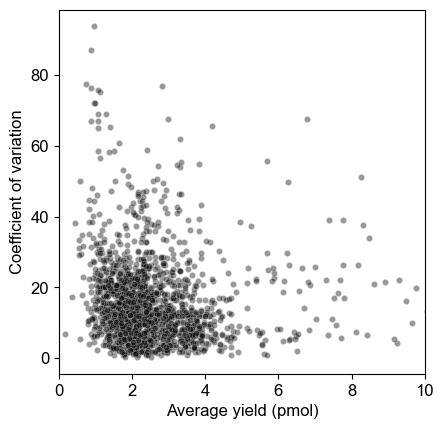

Number of points in plot: 16.3%


In [8]:
plt.rcParams['font.size'] = 12

fig,ax = plt.subplots(figsize=[12*cm,12*cm])

sns.scatterplot(data=calcs,x='pmol_mean',y='pmol_cv',alpha=0.4,s=20,color='black',ax=ax)
ax.set_xlim(0,10)
ax.set_xlabel('Average yield (pmol)')
ax.set_ylabel('Coefficient of variation')
plt.savefig(f'{fig_folder}/Supp_fig-screen_mean_cv_plot.svg',format='svg',dpi=300)

plt.show()
print(f'Number of points in plot: {round(calcs.pmol_cv.mean(),2)}%')
plt.rcParams['font.size'] = 7


In [9]:
print(f'Number of points in plot: {len(calcs)}')

Number of points in plot: 1682


### Setting the 1 pmol threshold for the yield difference
* The threshold is set to minimize the likelihood of a false positive
* We assume that if out of 100 compositions within a range of yield differences, only 10 of them are found to be significant then I am less likely to trust that those 10 are true hits
* If instead 90 out of the 100 are significant, I am much more confident they would be true positives
* In this case we are setting the threshold to 80% which equates to a 1 pmol threshold.

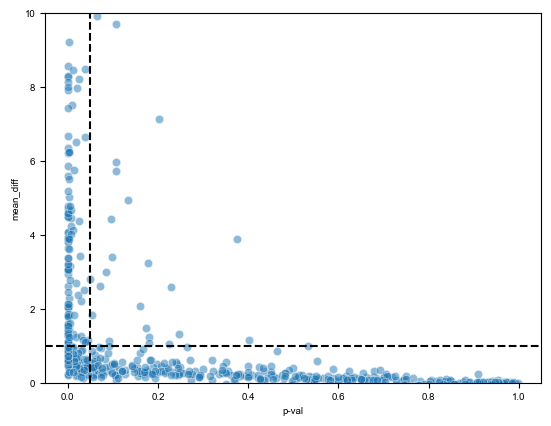

In [10]:
temp = sub_df[sub_df['Liposome_name'] != 'no_lipo'].copy()
temp = temp[['DNA_name','rxn_id','mean_diff','p-val']].drop_duplicates()
temp
sns.scatterplot(data=temp,x='p-val',y='mean_diff',alpha=0.5)
plt.ylim(0,10)
plt.axvline(0.05,color='k',ls='--')
plt.axhline(1,color='k',ls='--')
plt.show()

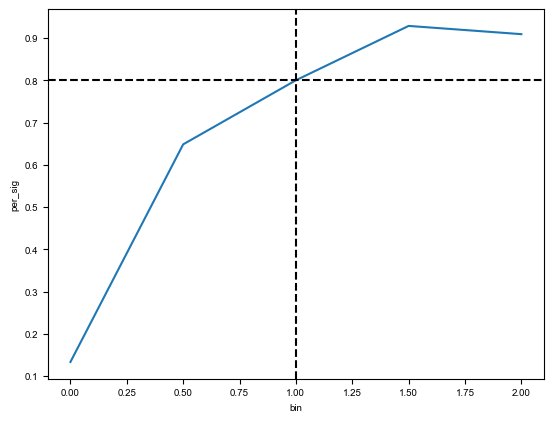

,bin,sig,unsig,total,per_sig
0,0.0,39,253,292,0.133562
1,0.5,59,32,91,0.648352
2,1.0,28,7,35,0.800000
3,1.5,13,1,14,0.928571
4,2.0,10,1,11,0.909091


In [11]:
bins = np.arange(0,2.25,0.5)

temp = sub_df[sub_df['Liposome_name'] != 'no_lipo'].copy()
temp = temp[['DNA_name','rxn_id','mean_diff','p-val']].drop_duplicates()

scores = []

for b in bins:
    sig = len(temp[(temp['mean_diff'].between(b,b+0.5)) & (temp['p-val'] < 0.05)])
    unsig = len(temp[(temp['mean_diff'].between(b,b+0.5)) & (temp['p-val'] > 0.05)])
    scores.append([b,sig,unsig])
    
scores = pd.DataFrame(scores,columns=['bin','sig','unsig'])
scores['total'] = scores['sig'] + scores['unsig']
scores['per_sig'] = scores['sig'] / scores['total']
scores
sns.lineplot(data=scores,x='bin',y='per_sig')
plt.axvline(1,color='k',ls='--')
plt.axhline(0.8,color='k',ls='--')
plt.show()
scores

## Fig 2C - Calculate the percentage of succcessful reactions for each protein

In [12]:
unique = sub_df.drop_duplicates(subset=['rxn_id']).copy()
total = unique.groupby(['DNA_name']).agg(len)['score']
total.describe()

count    28.00000
mean     33.00000
std      13.18248
min      24.00000
25%      24.00000
50%      28.00000
75%      36.00000
max      68.00000
Name: score, dtype: float64

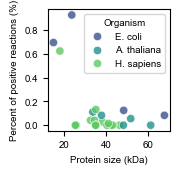

In [13]:
unique = sub_df.drop_duplicates(subset=['rxn_id']).copy()
total = unique.groupby(['DNA_name']).agg(len)['score']
low = unique[unique['score'] == 0].groupby(['DNA_name']).agg(len)['score']
high = unique[unique['score'] == 1].groupby(['DNA_name']).agg(len)['score']
counts = pd.concat([total,low,high],axis=1).fillna(0)
counts.columns = ['total','bad','good']
counts['percent_good'] = counts['good'] / counts['total']
counts = counts.join(meta)

fig,ax = plt.subplots(figsize=[4*cm,4*cm])

sns.scatterplot(data=counts,x='Mass',y='percent_good',hue='Organism',palette='viridis',alpha=0.8)

plt.xlabel('Protein size (kDa)')
plt.ylabel('Percent of positive reactions (%)')

# plt.savefig(f'{fig_folder}/Fig2C-percent_positive_organism_1pmol.svg',format='svg',dpi=300)
plt.show()

### Fig 2C - Statistics

In [14]:
small = counts[counts['Mass'] < 25].copy()
large = counts[counts['Mass'] >= 25].copy()
avg_small = small['percent_good'].mean()
avg_large = large['percent_good'].mean()

print(f'small:{avg_small}% - large:{round(avg_large,2)}%')

human = large[large['Organism'] == 'H. sapiens']['percent_good']
coli = large[large['Organism'] == 'E. coli']['percent_good']
plant = large[large['Organism'] == 'A. thaliana']['percent_good']

human_plant = ttest_ind(human,plant)[1]
human_coli = ttest_ind(human,coli)[1]
print(round(human_plant,2),round(human_coli,4))
print(human.mean(),plant.mean(),coli.mean())

small:0.75% - large:0.03%
0.07 0.0017
0.014342774146695714 0.05 0.10416666666666666


In [15]:
# counts.to_excel(f'{data_folder}/Fig2C-Protein_percentages.xlsx')

## Fig 2B - Reaction composition outcome volcano plot
* Defines the standard reaction composition

In [16]:
exp_variables = ['DNA_name','Mg','K','PEG','Liposome_name','SecYE']
sub_lipo = sub_df[sub_df['Liposome_name'] != 'no_lipo']
means = sub_lipo.groupby(exp_variables)[['pmol','pmol_sub_nolipo']].agg('mean')
stdevs = sub_lipo.groupby(exp_variables)[['pmol','pmol_sub_nolipo']].agg('std')
lengths = sub_lipo.groupby(exp_variables)[['pmol']].agg(len)
pvals = sub_lipo.groupby(exp_variables)[['p-val']].agg('mean')
lengths = lengths.rename(columns={'pmol':'count'})
cvs = abs(stdevs / means)
cvs = cvs.rename(columns={'pmol':'pmol_cv','pmol_sub_nolipo':'pmol_sub_nolipo_cv'})
cvs['pmol_cv'] = cvs['pmol_cv'].clip(0.001,2)
cvs['pmol_sub_nolipo_cv'] = cvs['pmol_sub_nolipo_cv'].clip(0.001,2)
calcs = means.join(stdevs,lsuffix='_mean',rsuffix='_stdev').join(cvs).join(lengths).join(pvals).reset_index()
calcs['log_pval'] = -1*np.log(calcs['p-val'])
calcs

,DNA_name,Mg,K,PEG,Liposome_name,SecYE,pmol_mean,pmol_sub_nolipo_mean,pmol_stdev,pmol_sub_nolipo_stdev,pmol_cv,pmol_sub_nolipo_cv,count,p-val,log_pval
0,AqpZ,8.0,85,0.0,DMPC,1.25,6.510816,3.820765,0.125056,0.125056,0.019207,0.032731,3,9.339871e-07,13.883803
1,AqpZ,8.0,85,0.0,DOPC,0.00,7.785206,4.576582,1.332032,1.332032,0.171098,0.291054,3,1.460862e-03,6.528729
2,AqpZ,8.0,85,1.0,DOPC,1.25,8.184459,4.447655,2.167424,2.167424,0.264822,0.487318,4,6.894344e-03,4.977054
3,AqpZ,8.0,85,2.0,DMPC,0.00,6.228933,3.550307,1.844656,1.620566,0.296143,0.456458,9,3.388573e-03,5.687346
4,AqpZ,8.0,85,2.0,DMPC,1.25,4.736391,3.057849,0.296282,0.296282,0.062554,0.096892,5,2.439755e-08,17.528783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,Vol,20.0,85,2.0,DOPC,1.25,1.530247,-0.372422,0.192997,0.192997,0.126122,0.518222,6,3.587318e-02,3.327765
910,Vol,20.0,135,2.0,DMPC,0.00,1.380539,-0.218886,0.074480,0.074480,0.053950,0.340270,4,2.082508e-01,1.569012
911,Vol,20.0,135,2.0,DMPC,1.25,1.050260,-0.627036,0.066998,0.066998,0.063792,0.106849,4,2.083868e-02,3.870944
912,Vol,20.0,135,2.0,DOPC,0.00,1.312898,-0.286527,0.177833,0.177833,0.135451,0.620649,6,8.282475e-02,2.491028


In [17]:
standard = {
    'Mg':[12,14],
    'K':[85],
    'PEG':[2],
    'Liposome_name':['DOPC'],
    'SecYE':[0],
}

standard_df = calcs.copy()
for key in standard.keys():
    standard_df = standard_df[standard_df[key].isin(standard[key])]
dup = standard_df[(standard_df['DNA_name'].isin(['AqpZ','Glut','CD47','MscL']))]
non_dup = standard_df[(~standard_df['DNA_name'].isin(['AqpZ','Glut','CD47','MscL']))]
dup = dup[dup['Mg'] == 14].copy()
standard_df = pd.concat([non_dup,dup])

len(standard_df['DNA_name'].unique())

28

In [18]:
calcs

,DNA_name,Mg,K,PEG,Liposome_name,SecYE,pmol_mean,pmol_sub_nolipo_mean,pmol_stdev,pmol_sub_nolipo_stdev,pmol_cv,pmol_sub_nolipo_cv,count,p-val,log_pval
0,AqpZ,8.0,85,0.0,DMPC,1.25,6.510816,3.820765,0.125056,0.125056,0.019207,0.032731,3,9.339871e-07,13.883803
1,AqpZ,8.0,85,0.0,DOPC,0.00,7.785206,4.576582,1.332032,1.332032,0.171098,0.291054,3,1.460862e-03,6.528729
2,AqpZ,8.0,85,1.0,DOPC,1.25,8.184459,4.447655,2.167424,2.167424,0.264822,0.487318,4,6.894344e-03,4.977054
3,AqpZ,8.0,85,2.0,DMPC,0.00,6.228933,3.550307,1.844656,1.620566,0.296143,0.456458,9,3.388573e-03,5.687346
4,AqpZ,8.0,85,2.0,DMPC,1.25,4.736391,3.057849,0.296282,0.296282,0.062554,0.096892,5,2.439755e-08,17.528783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,Vol,20.0,85,2.0,DOPC,1.25,1.530247,-0.372422,0.192997,0.192997,0.126122,0.518222,6,3.587318e-02,3.327765
910,Vol,20.0,135,2.0,DMPC,0.00,1.380539,-0.218886,0.074480,0.074480,0.053950,0.340270,4,2.082508e-01,1.569012
911,Vol,20.0,135,2.0,DMPC,1.25,1.050260,-0.627036,0.066998,0.066998,0.063792,0.106849,4,2.083868e-02,3.870944
912,Vol,20.0,135,2.0,DOPC,0.00,1.312898,-0.286527,0.177833,0.177833,0.135451,0.620649,6,8.282475e-02,2.491028


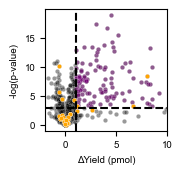

In [19]:
fig,ax = plt.subplots(figsize=[4*cm,4*cm])

x_thresh = 1
y_thresh = -np.log(0.05)

sns.scatterplot(data=calcs,x='pmol_sub_nolipo_mean',y='log_pval',alpha=0.4,color='black',s=10)
sns.scatterplot(data=calcs[(calcs['pmol_sub_nolipo_mean'] > x_thresh) & (calcs['log_pval'] > y_thresh)],x='pmol_sub_nolipo_mean',y='log_pval',s=10,alpha=0.4,color='purple')
sns.scatterplot(data=standard_df,x='pmol_sub_nolipo_mean',y='log_pval',alpha=1,color='orange',s=10)

plt.xlim([-2,10])

plt.axvline(x_thresh,color='black',ls='--')
plt.axhline(y_thresh,color='black',ls='--')
plt.xlabel('ΔYield (pmol)')
plt.ylabel('-log(p-value)')
# plt.savefig(f'{fig_folder}/Fig1B-volcano_plot_standard_orange_1pmol.svg',format='svg',dpi=300)

plt.show()

In [20]:
standard_percent = len(standard_df[(standard_df['pmol_sub_nolipo_mean'] > x_thresh) & (standard_df['log_pval'] > y_thresh)]) / len(standard_df) * 100
print(f'Percent of proteins that worked in the Standard composition: {round(standard_percent,2)}%')

Percent of proteins that worked in the Standard composition: 10.71%


In [21]:
export = calcs.rename(columns={'pmol_cv':'-log_pmol_cv'})
# export.to_excel(f'{data_folder}/Fig2B-Volcano_plot_data.xlsx')

## Fig2E - Reaction condition interdependence

In [22]:
exp_variables = ['DNA_name','Mg','K','PEG','Liposome_name','SecYE']

In [23]:
means = sub_lipo.groupby(exp_variables)[['pmol','pmol_sub_nolipo']].agg('mean')
stdevs = sub_lipo.groupby(exp_variables)[['pmol','pmol_sub_nolipo']].agg('std')
lengths = sub_lipo.groupby(exp_variables)[['pmol']].agg(len)
pvals = sub_lipo.groupby(exp_variables)[['p-val']].agg('mean')
lengths = lengths.rename(columns={'pmol':'count'})
cvs = abs(stdevs / means)
cvs = cvs.rename(columns={'pmol':'pmol_cv','pmol_sub_nolipo':'pmol_sub_nolipo_cv'})
cvs['pmol_cv'] = cvs['pmol_cv'].clip(0.001,2)
cvs['pmol_sub_nolipo_cv'] = cvs['pmol_sub_nolipo_cv'].clip(0.001,2)
calcs = means.join(stdevs,lsuffix='_mean',rsuffix='_stdev').join(cvs).join(lengths).join(pvals).reset_index()
calcs['log_pval'] = -1*np.log(calcs['p-val'])
calcs

,DNA_name,Mg,K,PEG,Liposome_name,SecYE,pmol_mean,pmol_sub_nolipo_mean,pmol_stdev,pmol_sub_nolipo_stdev,pmol_cv,pmol_sub_nolipo_cv,count,p-val,log_pval
0,AqpZ,8.0,85,0.0,DMPC,1.25,6.510816,3.820765,0.125056,0.125056,0.019207,0.032731,3,9.339871e-07,13.883803
1,AqpZ,8.0,85,0.0,DOPC,0.00,7.785206,4.576582,1.332032,1.332032,0.171098,0.291054,3,1.460862e-03,6.528729
2,AqpZ,8.0,85,1.0,DOPC,1.25,8.184459,4.447655,2.167424,2.167424,0.264822,0.487318,4,6.894344e-03,4.977054
3,AqpZ,8.0,85,2.0,DMPC,0.00,6.228933,3.550307,1.844656,1.620566,0.296143,0.456458,9,3.388573e-03,5.687346
4,AqpZ,8.0,85,2.0,DMPC,1.25,4.736391,3.057849,0.296282,0.296282,0.062554,0.096892,5,2.439755e-08,17.528783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,Vol,20.0,85,2.0,DOPC,1.25,1.530247,-0.372422,0.192997,0.192997,0.126122,0.518222,6,3.587318e-02,3.327765
910,Vol,20.0,135,2.0,DMPC,0.00,1.380539,-0.218886,0.074480,0.074480,0.053950,0.340270,4,2.082508e-01,1.569012
911,Vol,20.0,135,2.0,DMPC,1.25,1.050260,-0.627036,0.066998,0.066998,0.063792,0.106849,4,2.083868e-02,3.870944
912,Vol,20.0,135,2.0,DOPC,0.00,1.312898,-0.286527,0.177833,0.177833,0.135451,0.620649,6,8.282475e-02,2.491028


### Examples of reaction variable interdependence

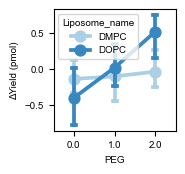

24


In [24]:
fig,ax = plt.subplots(figsize=[4*cm,4*cm])
t = calcs[calcs['DNA_name'] == 'FFAR4']
t = t[t['Liposome_name'] != 'DPPC']
sns.pointplot(data=t,x='PEG',y='pmol_sub_nolipo_mean',hue='Liposome_name',palette='Blues',capsize=.1)
plt.ylabel('ΔYield (pmol)')
# plt.savefig(f'{fig_folder}/Supp_fig-pointplot_FFAR4_PEGxlipid_endcaps.svg',format='svg',dpi=300)

plt.show()
# t.to_excel(f'{data_folder}/Supp_fig-interdependence-FFAR4_PEGxlipid_endcaps.xlsx')
print(len(t))

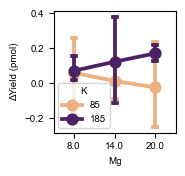

In [33]:
fig,ax = plt.subplots(figsize=[4*cm,4*cm])
t = calcs[calcs['DNA_name'] == 'OR2AG1']
t = t[t['Liposome_name'] != 'DPPC']
sns.pointplot(data=t,x='Mg',y='pmol_sub_nolipo_mean',hue='K',palette='flare',capsize=.1)
plt.ylabel('ΔYield (pmol)')
# plt.savefig(f'{fig_folder}/Supp_fig-pointplot_OR2AG1_MgxK_endcaps.svg',format='svg',dpi=300)

plt.show()
# t.to_excel(f'{data_folder}/Supp_fig-interdependence-OR2AG1_MgxK_endcaps.xlsx')

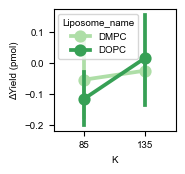

In [27]:
fig,ax = plt.subplots(figsize=[4*cm,4*cm])
t = calcs[calcs['DNA_name'] == 'Neu']
# t = t[t['Liposome_name'] != 'DPPC']
sns.pointplot(data=t,x='K',y='pmol_sub_nolipo_mean',hue='Liposome_name',palette='Greens')
plt.ylabel('ΔYield (pmol)')
# plt.savefig(f'{fig_folder}/Supp_fig-pointplot_Neu_Kxlipid.svg',format='svg',dpi=300)

plt.show()
# t.to_excel(f'{data_folder}/Supp_fig-interdependence-Neu_Kxlipid.xlsx')

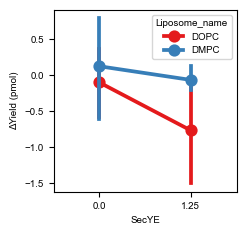

In [28]:
fig,ax = plt.subplots(figsize=[6*cm,6*cm])
t = calcs[calcs['DNA_name'] == 'CaM']
t = t[t['Liposome_name'] != 'DPPC']
sns.pointplot(data=t,x='SecYE',y='pmol_sub_nolipo_mean',hue='Liposome_name',palette='Set1')
plt.ylabel('ΔYield (pmol)')
# plt.savefig(f'{fig_folder}/pointplot_Beta.svg',format='svg',dpi=300)

plt.show()

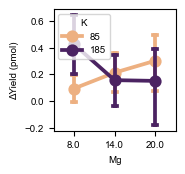

24


In [35]:
fig,ax = plt.subplots(figsize=[4*cm,4*cm])
t = calcs[calcs['DNA_name'] == 'CD9']
t = t[t['Liposome_name'] != 'DPPC']
sns.pointplot(data=t,x='Mg',y='pmol_sub_nolipo_mean',hue='K',palette='flare',capsize=.1)
plt.ylabel('ΔYield (pmol)')
# plt.savefig(f'{fig_folder}//Supp_fig-interdependence-CD9_MgxK_endcaps.svg',format='svg',dpi=300)

plt.show()
# t.to_excel(f'{data_folder}/Supp_fig-interdependence-CD9_MgxK_endcaps.xlsx')
print(len(t))

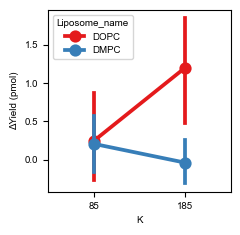

In [36]:
fig,ax = plt.subplots(figsize=[6*cm,6*cm])
t = calcs[calcs['DNA_name'] == 'Beta']
t = t[t['Liposome_name'] != 'DPPC']
sns.pointplot(data=t,x='K',y='pmol_sub_nolipo_mean',hue='Liposome_name',palette='Set1')
plt.ylabel('ΔYield (pmol)')
# plt.savefig(f'{fig_folder}/pointplot_Beta.svg',format='svg',dpi=300)

plt.show()

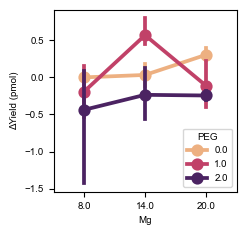

In [38]:
fig,ax = plt.subplots(figsize=[6*cm,6*cm])
t = calcs[calcs['DNA_name'] == 'B3AR']
t = t[t['Liposome_name'] != 'DPPC']
sns.pointplot(data=t,x='Mg',y='pmol_sub_nolipo_mean',hue='PEG',palette='flare')
plt.ylabel('ΔYield (pmol)')
# plt.savefig(f'{fig_folder}/pointplot_B3AR.svg',format='svg',dpi=300)

# sns.pointplot(data=t,x='PEG',y='pmol_sub_nolipo_mean',hue='Mg',palette='viridis')
# plt.title(dna)
plt.show()

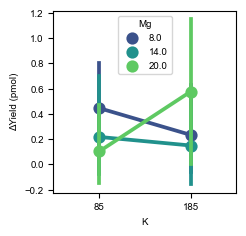

In [50]:
fig,ax = plt.subplots(figsize=[6*cm,6*cm])
t = calcs[calcs['DNA_name'] == 'OR1A1']
t = t[t['Liposome_name'] != 'DPPC']
sns.pointplot(data=t,x='K',y='pmol_sub_nolipo_mean',hue='Mg',palette='viridis')
plt.ylabel('ΔYield (pmol)')
# plt.savefig(f'{fig_folder}/pointplot_OR1A1.svg',format='svg',dpi=300)

# sns.pointplot(data=t,x='PEG',y='pmol_sub_nolipo_mean',hue='Mg',palette='viridis')
# plt.title(dna)
plt.show()

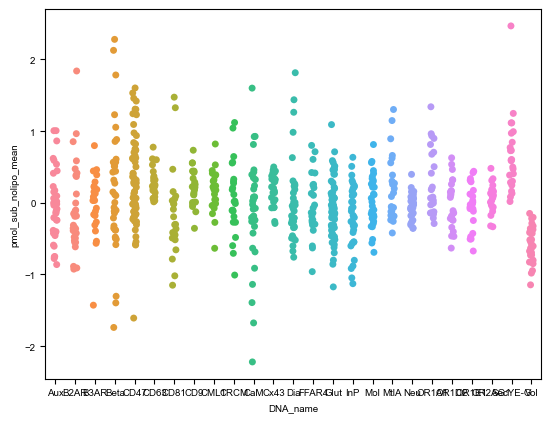

In [51]:
high = ['AqpZ','MscL','Mito']
sns.stripplot(data=calcs[~calcs['DNA_name'].isin(high)],x='DNA_name',y='pmol_sub_nolipo_mean')
plt.show()

### Assess linearity of variables per protein
* Fit individual OLS models to each protein
* Use the p-value for each term to indicate importance of the term

In [39]:
all_features = calcs.copy()
all_features
lipo_dict = {'DOPC':18,'DPPC':16,'DMPC':14,'no_lipo':0}
all_features['lipid'] = all_features['Liposome_name'].apply(lambda x: lipo_dict[x])

all_features = all_features.reset_index().rename(columns={'index':'rxn_id'})
data_bounded = all_features[['Mg', 'SecYE', 'K', 'PEG','lipid']]
X_bounded = np.array(data_bounded)
# MMscalerX = MinMaxScaler()
scalerX = StandardScaler()
X_bounded = scalerX.fit_transform(X_bounded)
data_bounded = pd.DataFrame(X_bounded,columns=data_bounded.columns)
data_bounded['rxn_id'] = all_features['rxn_id']
data_bounded = data_bounded.drop_duplicates().set_index('rxn_id')
data_bounded

,Mg,SecYE,K,PEG,lipid
rxn_id,,,,,
0,-1.259121,1.002191,-0.941864,-1.586735,-1.051682
1,-1.259121,-0.997814,-0.941864,-1.586735,1.047090
2,-1.259121,1.002191,-0.941864,-0.370061,1.047090
3,-1.259121,-0.997814,-0.941864,0.846613,-1.051682
4,-1.259121,1.002191,-0.941864,0.846613,-1.051682
...,...,...,...,...,...
909,1.264643,1.002191,-0.941864,0.846613,1.047090
910,1.264643,-0.997814,0.161807,0.846613,-1.051682
911,1.264643,1.002191,0.161807,0.846613,-1.051682


In [40]:
y_col = 'pmol_sub_nolipo_mean'
# y_col = 'pmol_mean'

transformed = []
scaler_dict = {}

for dna, dna_df in all_features.groupby('DNA_name'):
    temp = dna_df.copy()
    y_scaled = np.array(dna_df[[y_col]])
    scalerY = StandardScaler()
    y_scaled = scalerY.fit_transform(y_scaled)
    temp['label'] = y_scaled
    transformed.append(temp)
    scaler_dict.update({dna:scalerY})
transformed = pd.concat(transformed)
transformed = transformed[['rxn_id','label']].set_index('rxn_id')
transformed

,label
rxn_id,
0,0.143017
1,0.484792
2,0.426493
3,0.020718
4,-0.201968
...,...
909,0.838013
910,1.486934
911,-0.238115


In [41]:
dna_ids = all_features[['rxn_id','DNA_name']].drop_duplicates().set_index('rxn_id')
norm_data = data_bounded.join(transformed).join(dna_ids).reset_index()
norm_data

,rxn_id,Mg,SecYE,K,PEG,lipid,label,DNA_name
0,0,-1.259121,1.002191,-0.941864,-1.586735,-1.051682,0.143017,AqpZ
1,1,-1.259121,-0.997814,-0.941864,-1.586735,1.047090,0.484792,AqpZ
2,2,-1.259121,1.002191,-0.941864,-0.370061,1.047090,0.426493,AqpZ
3,3,-1.259121,-0.997814,-0.941864,0.846613,-1.051682,0.020718,AqpZ
4,4,-1.259121,1.002191,-0.941864,0.846613,-1.051682,-0.201968,AqpZ
...,...,...,...,...,...,...,...,...
909,909,1.264643,1.002191,-0.941864,0.846613,1.047090,0.838013,Vol
910,910,1.264643,-0.997814,0.161807,0.846613,-1.051682,1.486934,Vol
911,911,1.264643,1.002191,0.161807,0.846613,-1.051682,-0.238115,Vol
912,912,1.264643,-0.997814,0.161807,0.846613,1.047090,1.201048,Vol


#### Generate the linear model by creating all pairwise variable combinations

In [42]:
possible = ['Mg','SecYE','K','PEG','lipid']

combinations = list(itertools.combinations(possible, 2))

model_data = norm_data.copy()

for [left,right] in combinations:
    col_name = '_'.join([left,right])
    model_data[col_name] = model_data[left] * model_data[right]
model_data

,rxn_id,Mg,SecYE,K,PEG,lipid,label,DNA_name,Mg_SecYE,Mg_K,Mg_PEG,Mg_lipid,SecYE_K,SecYE_PEG,SecYE_lipid,K_PEG,K_lipid,PEG_lipid
0,0,-1.259121,1.002191,-0.941864,-1.586735,-1.051682,0.143017,AqpZ,-1.261879,1.185921,1.997891,1.324195,-0.943927,-1.590211,-1.053986,1.494488,0.990542,1.668740
1,1,-1.259121,-0.997814,-0.941864,-1.586735,1.047090,0.484792,AqpZ,1.256369,1.185921,1.997891,-1.318412,0.939805,1.583266,-1.044801,1.494488,-0.986216,-1.661453
2,2,-1.259121,1.002191,-0.941864,-0.370061,1.047090,0.426493,AqpZ,-1.261879,1.185921,0.465951,-1.318412,-0.943927,-0.370871,1.049383,0.348547,-0.986216,-0.387487
3,3,-1.259121,-0.997814,-0.941864,0.846613,-1.051682,0.020718,AqpZ,1.256369,1.185921,-1.065989,1.324195,0.939805,-0.844763,1.049383,-0.797395,0.990542,-0.890368
4,4,-1.259121,1.002191,-0.941864,0.846613,-1.051682,-0.201968,AqpZ,-1.261879,1.185921,-1.065989,1.324195,-0.943927,0.848468,-1.053986,-0.797395,0.990542,-0.890368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,909,1.264643,1.002191,-0.941864,0.846613,1.047090,0.838013,Vol,1.267414,-1.191122,1.070664,1.324195,-0.943927,0.848468,1.049383,-0.797395,-0.986216,0.886480
910,910,1.264643,-0.997814,0.161807,0.846613,-1.051682,1.486934,Vol,-1.261879,0.204629,1.070664,-1.330003,-0.161454,-0.844763,1.049383,0.136988,-0.170170,-0.890368
911,911,1.264643,1.002191,0.161807,0.846613,-1.051682,-0.238115,Vol,1.267414,0.204629,1.070664,-1.330003,0.162162,0.848468,-1.053986,0.136988,-0.170170,-0.890368
912,912,1.264643,-0.997814,0.161807,0.846613,1.047090,1.201048,Vol,-1.261879,0.204629,1.070664,1.324195,-0.161454,-0.844763,-1.044801,0.136988,0.169427,0.886480


In [43]:
col_string = ' + '.join(model_data.drop(columns=['rxn_id','label','DNA_name']).columns.tolist())

In [44]:
col_string

'Mg + SecYE + K + PEG + lipid + Mg_SecYE + Mg_K + Mg_PEG + Mg_lipid + SecYE_K + SecYE_PEG + SecYE_lipid + K_PEG + K_lipid + PEG_lipid'

In [45]:
formula = f'label ~ {col_string}'

all_model_data = []
for dna,dna_df in model_data.groupby('DNA_name'):
    model = sm.OLS.from_formula(formula, data=dna_df)
    result = model.fit()
    summary_data = pd.DataFrame({'variable': result.model.exog_names})
    summary_data['coef'] = result.params.tolist()
    summary_data['pval'] = result.pvalues.tolist()
    summary_data['rsquare'] = result.rsquared
    summary_data['DNA_name'] = dna
    all_model_data.append(summary_data)
    
all_model_data = pd.concat(all_model_data)
all_model_data

,variable,coef,pval,rsquare,DNA_name
0,Intercept,0.229041,8.549452e-03,0.781946,AqpZ
1,Mg,-0.079926,3.407330e-01,0.781946,AqpZ
2,SecYE,-0.479596,8.059539e-07,0.781946,AqpZ
3,K,-0.046876,6.017314e-01,0.781946,AqpZ
4,PEG,-0.668709,3.526767e-09,0.781946,AqpZ
...,...,...,...,...,...
11,SecYE_PEG,0.046531,5.535310e-01,0.656124,Vol
12,SecYE_lipid,0.137012,2.738724e-01,0.656124,Vol
13,K_PEG,0.520773,1.728751e-04,0.656124,Vol
14,K_lipid,-0.098889,6.590892e-01,0.656124,Vol


In [46]:
new_cols = [v.replace('_',' x ') for v in all_model_data['variable'].tolist()]
col_dict = dict(list(zip(all_model_data['variable'].tolist(),new_cols)))
all_model_data['variable'] = all_model_data['variable'].apply(lambda x: col_dict[x])

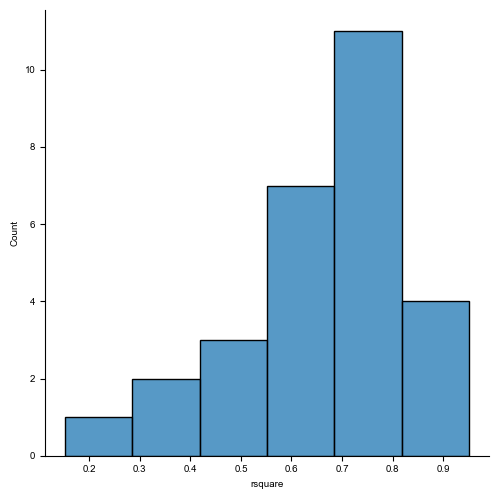

In [47]:
sns.displot(data=all_model_data.reset_index().drop_duplicates(subset='DNA_name'),x='rsquare')
plt.show()

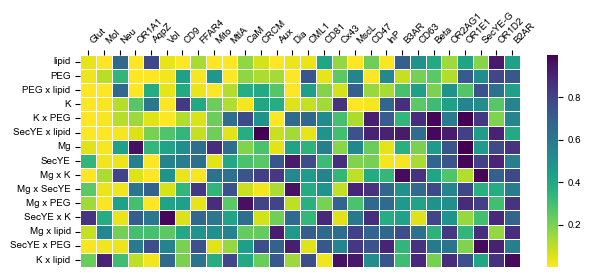

In [49]:
# pvals = all_model_data[['DNA_name','variable','pval']].set_index(['DNA_name','variable']).unstack()
pvals = all_model_data[all_model_data['variable']!='Intercept'][['DNA_name','variable','pval']]
variable_order = pvals[['variable','pval']].groupby('variable').agg('mean').sort_values('pval',ascending=True).reset_index()['variable'].tolist()
protein_order = pvals[['DNA_name','pval']].groupby('DNA_name').agg('mean').sort_values('pval',ascending=True).reset_index()['DNA_name'].tolist()

pvals = pvals.set_index(['DNA_name','variable']).unstack()
pvals.columns = pvals.columns.droplevel()
pvals = pvals[variable_order]
pvals
pvals = pvals.reindex(protein_order)
pvals = pvals.T
# pvals.columns = pvals.columns.droplevel()

fig,ax = plt.subplots(figsize=[18*cm,7*cm])

ax = sns.heatmap(data=pvals,cmap='viridis_r',ax=ax,linewidth=0.5)
ax.xaxis.tick_top()
# ax.set(xticklabels=[])
# ax.set(yticklabels=[])
plt.xticks(rotation=45, ha='left')
plt.yticks(rotation=0)
plt.xlabel('')
plt.ylabel('')
# plt.savefig(f'{fig_folder}/Fig2E-interaction_significance_sub_pmol.svg',format='svg',dpi=300)

plt.show()

#### Statistics

In [50]:
mins = pvals.min(axis=1)
print(len(pvals), len(mins[mins < 0.05]))
counts = []
for v,row in pvals.iterrows():
    counts.append([v,len(row[row < 0.05])])
counts = pd.DataFrame(counts,columns=['term','sign'])
counts
print(f'At least 1 count:{len(counts[counts.sign > 0])}')
print(f'At least 5 count:{len(counts[counts.sign >= 5]) / len(counts)}')

15 14
At least 1 count:14
At least 5 count:0.4666666666666667


In [63]:
pvals.to_excel(f'{data_folder}/Fig2E-interdependence.xlsx')

# Fig 2D - Plotting reaction condition preference
* Normalize all reaction conditions with a min-max scaler
* Z-score the yields using a standard scaler
* Take the top three producing reaction compositions for each protein to identify preference
* Uses the protein order set in the reaction condition interdependence so the plots can be stacked

In [51]:
all_features = calcs.copy()
all_features
lipo_dict = {'DOPC':18,'DPPC':16,'DMPC':14,'no_lipo':0}
all_features['lipid'] = all_features['Liposome_name'].apply(lambda x: lipo_dict[x])

all_features = all_features.reset_index().rename(columns={'index':'rxn_id'})
data_bounded = all_features[['Mg', 'SecYE', 'K', 'PEG','lipid']]
X_bounded = np.array(data_bounded)
MMscalerX = MinMaxScaler()
X_bounded = MMscalerX.fit_transform(X_bounded)
data_bounded = pd.DataFrame(X_bounded,columns=data_bounded.columns)
data_bounded['rxn_id'] = all_features['rxn_id']
data_bounded = data_bounded.drop_duplicates().set_index('rxn_id')
data_bounded

,Mg,SecYE,K,PEG,lipid
rxn_id,,,,,
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.5,1.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...
909,1.0,1.0,0.0,1.0,1.0
910,1.0,0.0,0.5,1.0,0.0
911,1.0,1.0,0.5,1.0,0.0


In [52]:
y_col = 'pmol_sub_nolipo_mean'

transformed = []
scaler_dict = {}

for dna, dna_df in all_features.groupby('DNA_name'):
    temp = dna_df.copy()
    y_scaled = np.array(dna_df[[y_col]])
    scalerY = StandardScaler()
    y_scaled = scalerY.fit_transform(y_scaled)
    temp['label'] = y_scaled
    transformed.append(temp)
    scaler_dict.update({dna:scalerY})
transformed = pd.concat(transformed)
transformed = transformed[['rxn_id','label']].set_index('rxn_id')
transformed

,label
rxn_id,
0,0.143017
1,0.484792
2,0.426493
3,0.020718
4,-0.201968
...,...
909,0.838013
910,1.486934
911,-0.238115


In [53]:
dna_ids = all_features[['rxn_id','DNA_name']].drop_duplicates().set_index('rxn_id')
norm_data = data_bounded.join(transformed).join(dna_ids).reset_index()
norm_data

,rxn_id,Mg,SecYE,K,PEG,lipid,label,DNA_name
0,0,0.0,1.0,0.0,0.0,0.0,0.143017,AqpZ
1,1,0.0,0.0,0.0,0.0,1.0,0.484792,AqpZ
2,2,0.0,1.0,0.0,0.5,1.0,0.426493,AqpZ
3,3,0.0,0.0,0.0,1.0,0.0,0.020718,AqpZ
4,4,0.0,1.0,0.0,1.0,0.0,-0.201968,AqpZ
...,...,...,...,...,...,...,...,...
909,909,1.0,1.0,0.0,1.0,1.0,0.838013,Vol
910,910,1.0,0.0,0.5,1.0,0.0,1.486934,Vol
911,911,1.0,1.0,0.5,1.0,0.0,-0.238115,Vol
912,912,1.0,0.0,0.5,1.0,1.0,1.201048,Vol


In [54]:
num_count = 3

all_high = []
for dna,dna_df in norm_data.groupby('DNA_name'):
    high = dna_df.sort_values('label',ascending=False).iloc[:num_count]
    all_high.append(high)

all_high = pd.concat(all_high)
all_high

,rxn_id,Mg,SecYE,K,PEG,lipid,label,DNA_name
41,41,1.000000,0.0,0.0,0.5,1.0,3.164451,AqpZ
39,39,1.000000,0.0,0.0,0.0,0.0,2.589555,AqpZ
12,12,0.000000,0.0,1.0,0.5,0.0,2.156232,AqpZ
76,76,0.500000,0.0,1.0,1.0,0.0,2.151400,Aux
56,56,0.000000,0.0,0.0,0.5,0.0,2.150640,Aux
...,...,...,...,...,...,...,...,...
877,877,1.000000,1.0,0.0,1.0,1.0,1.160604,SecYE-G
869,869,0.500000,0.0,0.0,1.0,1.0,0.901453,SecYE-G
897,897,0.333333,1.0,0.5,1.0,1.0,1.785297,Vol
889,889,0.000000,1.0,0.5,1.0,1.0,1.554318,Vol


['lipid', 'PEG', 'K', 'Mg', 'SecYE']


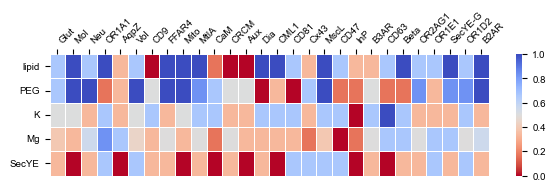

In [58]:
heat = all_high.groupby('DNA_name').agg('mean').reset_index().drop(columns=['rxn_id','label']).set_index('DNA_name')
heat['mean'] = heat.mean(axis=1)
heat = heat.sort_values('mean',ascending=False)
heat = heat.drop(columns=['mean'])
var_order = heat.T.mean(axis=1).reset_index().sort_values(0,ascending=False)['index'].tolist()
print(var_order)
heat = heat[var_order]
heat = heat.T[protein_order]

fig,ax = plt.subplots(figsize=[18*cm,4*cm])

ax = sns.heatmap(data=heat,cmap='coolwarm_r',ax=ax,linewidth=.5)
ax.xaxis.tick_top()
plt.xticks(rotation=45, ha='left')
plt.yticks(rotation=0)
plt.xlabel('')
# plt.savefig(f'{fig_folder}/Fig2D-protein_preference-coolwarm-sub_pmol.svg',format='svg',dpi=300)

plt.show()

In [59]:
all_high[all_high['DNA_name'] == 'Vol']

,rxn_id,Mg,SecYE,K,PEG,lipid,label,DNA_name
897,897,0.333333,1.0,0.5,1.0,1.0,1.785297,Vol
889,889,0.000000,1.0,0.5,1.0,1.0,1.554318,Vol
910,910,1.000000,0.0,0.5,1.0,0.0,1.486934,Vol


['lipid', 'PEG', 'K', 'Mg', 'SecYE']


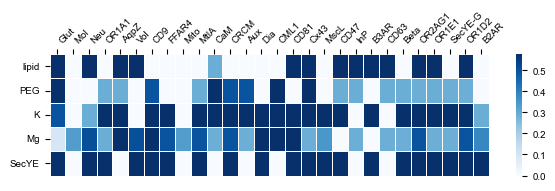

DNA_name,Glut,Mol,Neu,OR1A1,AqpZ,Vol,CD9,FFAR4,Mito,MtlA,...,CD47,InP,B3AR,CD63,Beta,OR2AG1,OR1E1,SecYE-G,OR1D2,B2AR
lipid,0.577350,0.000000,0.577350,0.000000,0.577350,0.577350,0.00000,0.00000,0.000000,0.000000,...,0.577350,0.577350,0.57735,0.577350,0.000000,0.577350,0.577350,0.000000,0.577350,0.000000
PEG,0.577350,0.000000,0.000000,0.288675,0.288675,0.000000,0.50000,0.00000,0.000000,0.288675,...,0.288675,0.288675,0.00000,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.000000
K,0.500000,0.000000,0.288675,0.577350,0.577350,0.000000,0.57735,0.57735,0.000000,0.577350,...,0.577350,0.000000,0.57735,0.000000,0.577350,0.577350,0.577350,0.577350,0.577350,0.288675
Mg,0.096225,0.333333,0.509175,0.288675,0.577350,0.509175,0.57735,0.50000,0.333333,0.500000,...,0.000000,0.288675,0.00000,0.288675,0.288675,0.500000,0.288675,0.288675,0.500000,0.384900
SecYE,0.577350,0.000000,0.577350,0.577350,0.000000,0.577350,0.57735,0.57735,0.000000,0.577350,...,0.577350,0.000000,0.57735,0.000000,0.577350,0.577350,0.577350,0.577350,0.577350,0.577350


In [61]:
heat = all_high.groupby('DNA_name').agg('std').reset_index().drop(columns=['rxn_id','label']).set_index('DNA_name')
print(var_order)
heat = heat[var_order]
heat = heat.T[protein_order]

fig,ax = plt.subplots(figsize=[18*cm,4*cm])

ax = sns.heatmap(data=heat,cmap='Blues',ax=ax,linewidth=.5)
ax.xaxis.tick_top()
plt.xticks(rotation=45, ha='left')
plt.yticks(rotation=0)
plt.xlabel('')
# plt.savefig(f'{fig_folder}/Fig2D-protein_preference-coolwarm-sub_pmol.svg',format='svg',dpi=300)

plt.show()
# heat[heat['DNA_name'] == 'Vol']
heat

#### Statistics

In [63]:
avg = all_high.groupby('DNA_name').agg('mean')
print('Means:\n',avg.mean(axis=0))
print('Standard deviations:\n',avg.std(axis=0))

print()

all_variables = ['lipid','PEG','Mg','SecYE','K']
for v in all_variables:
    high = len(avg[avg[v] > 0.7])
    low = len(avg[avg[v] < 0.3])
    strong_pref = (high + low) / len(avg) *100
    print(f'{v} - High:{high}\tLow:{low}\tstrong preference:{round(strong_pref,1)}%')
    
    high = len(avg[avg[v] > 0.7]) / len(avg) *100
    low = len(avg[avg[v] < 0.3]) / len(avg) *100
    print(f'{v} - High:{round(high,1)}%\tLow:{round(low,1)}%')


Means:
 rxn_id    478.452381
Mg          0.440476
SecYE       0.333333
K           0.511905
PEG         0.577381
lipid       0.660714
label       1.870145
dtype: float64
Standard deviations:
 rxn_id    270.298055
Mg          0.188809
SecYE       0.256600
K           0.202498
PEG         0.346891
lipid       0.346891
label       0.331958
dtype: float64

lipid - High:11	Low:4	strong preference:53.6%
lipid - High:39.3%	Low:14.3%
PEG - High:11	Low:7	strong preference:64.3%
PEG - High:39.3%	Low:25.0%
Mg - High:1	Low:4	strong preference:17.9%
Mg - High:3.6%	Low:14.3%
SecYE - High:0	Low:8	strong preference:28.6%
SecYE - High:0.0%	Low:28.6%
K - High:1	Low:1	strong preference:7.1%
K - High:3.6%	Low:3.6%


In [64]:
avg = all_high.groupby('DNA_name').agg('mean')

dopc = len(avg[avg['lipid'] >= 0.5])
dmpc = len(avg[avg['lipid'] < 0.5])
strong_lipid_pref = (dopc + dmpc) / len(avg) *100
print(f'lipid - DOPC:{dopc} DMPC:{dmpc} strong preference:{round(strong_lipid_pref,1)}%')


high_peg = len(avg[avg['PEG'] >= 0.5])
low_peg = len(avg[avg['PEG'] < 0.5])
strong_peg_pref = (high_peg + low_peg) / len(avg) *100
print(f'PEG - High:{high_peg} Low:{low_peg} strong preference:{round(strong_peg_pref,1)}%')


lipid - DOPC:20 DMPC:8 strong preference:100.0%
PEG - High:18 Low:10 strong preference:100.0%


In [64]:
heat.to_excel(f'{data_folder}/Fig2D-reaction_preference.xlsx')

<Axes: xlabel='DNA_name', ylabel='label'>

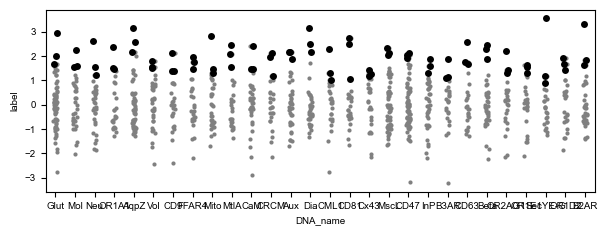

In [65]:
fig,ax = plt.subplots(figsize=[18*cm,6*cm])

sns.stripplot(data=norm_data,x='DNA_name',y='label',order=protein_order,ax=ax,color='grey',s=3)
sns.stripplot(data=all_high,x='DNA_name',y='label',order=protein_order,ax=ax,color='black')